# TIRAVEL_Quickstart

### The notebook contains an RV calculation refinement tool, based on Zucker & Mazeh 2006 TIRAVEL - Template Independent RAdial VELocity measurement (arXiv:astro-ph/0607293).

This partial implementation of the TIRAVEL method enables using initial observation RV values to create a template for more accurate RV extraction.

To demonstrate our RV extraction and refinement process, we use HARPS observations of LTT 9779 (TOI-193) used by Jenkins Et. Al. to detect an ultra-hot Neptune with a period of 0.79 days (arXiv:2009.12832).


### 1 Imports & funcs

In [1]:
import sys

from sparta.Auxil.PeriodicityDetector import PeriodicityDetector
from sparta.UNICOR.Spectrum import Spectrum
from sparta.UNICOR.Template import Template
from sparta.Auxil.TimeSeries import TimeSeries
from sparta.Observations import Observations
import numpy as np
import random
from scipy import interpolate
from PyAstronomy import pyasl
import matplotlib.pyplot as plt
from scipy import signal
from copy import deepcopy

### 2 Using the Observations class to read and process the TOI-193 HARPS observations.

`Observations` class enables one to load observation data from a given folder 
and place it into a TimeSeries object.

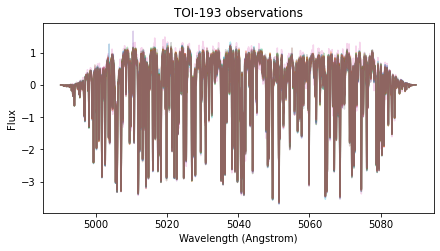

16 epochs.


In [2]:
# Note we used sample_rate to sampple only half of the available observations
obs_data = Observations(survey='HARPS', target_visits_lib='data/TOI193/', min_wv=4990, max_wv=5090, sample_rate=2)

for i in obs_data.time_series.vals:
    i = i.SpecPreProccess()
    
plt.figure(figsize=(7, 3.5)) 
plt.title("TOI-193 observations")
plt.ylabel("Flux")
plt.xlabel("Wavelength (Angstrom)")

for i, s in enumerate(obs_data.time_series.vals):
        plt.plot(s.wv[0], s.sp[0], alpha=0.3)

plt.show()

print(len(obs_data.time_series.vals), "epochs.")

### 3 Using the Template class to download and process a matching library template.

`Template` class enables downloading and processing PHEONIX library template for RV extraction.
Here we use the published TOI-193 parameters. We also applying rotational and gaussian broadening to the spectrum.

In [3]:
# Loading a Phoenix synthetic spectrum
t = Template(temp=5500, log_g=4.5, metal=0, alpha=0, min_val=4980, max_val=5100, air=False)
template_star_broadend = Template(template=Spectrum(wv=t.model.wv, sp=t.model.sp).InterpolateSpectrum())

v_sin_i = 1.5
print('RotationalBroadening.', end=' ')
template_star_broadend.RotationalBroadening(epsilon=0.5, vsini=v_sin_i)
template_star_broadend = deepcopy(Template(template=Spectrum(wv=[template_star_broadend.model.wv[0]], sp=[template_star_broadend.model.sp[0]]).SpecPreProccess()))
template_star_broadend = Template(template=Spectrum(wv=template_star_broadend.model.wv, sp=template_star_broadend.model.sp).InterpolateSpectrum(delta=0.5))

print('GaussianBroadening.', end=' ')
template_star_broadend.GaussianBroadening(resolution=115_000)


template_star_final = Template(template=Spectrum(wv=template_star_broadend.model.wv, sp=template_star_broadend.model.sp).SpecPreProccess())


RotationalBroadening. GaussianBroadening. 

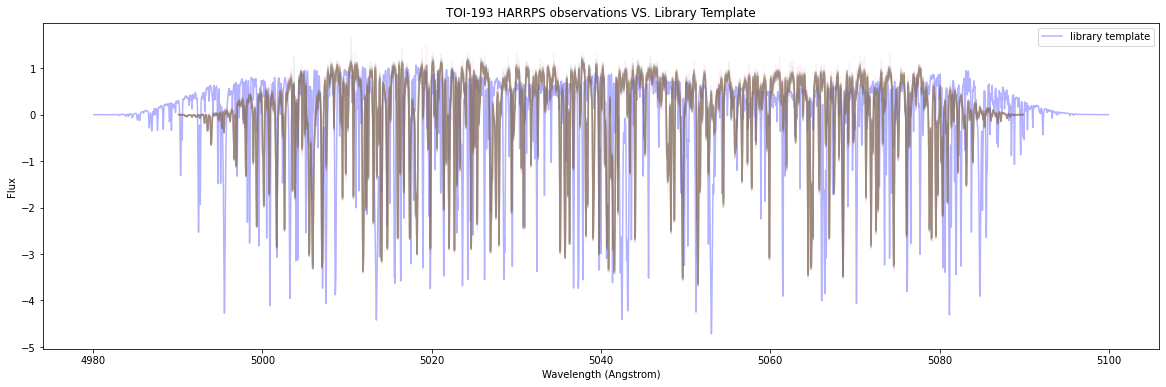

In [4]:
plt.figure(figsize=(20,6)) 
plt.title("TOI-193 HARRPS observations VS. Library Template")
plt.ylabel("Flux")
plt.xlabel("Wavelength (Angstrom)")

plt.plot(template_star_final.model.wv[0], template_star_final.model.sp[0], alpha=0.3, color="blue")

for i, s in enumerate(obs_data.time_series.vals):
    plt.plot(s.wv[0], s.sp[0], alpha=0.1)

plt.legend(["library template"])

plt.show()


### 3 Using fastccf method to extract RV values for the observations using the template.


In [5]:
calculated_vrad_list = obs_data.calc_rv_against_template(template_star_final, dv=0.1,  # 0.01
                                                         VelBound=[-117, 117], combine_ccfs=False,
                                                         fastccf=True).vels

100%|█| 16/16 [00:00<00:00, 20.71it/s


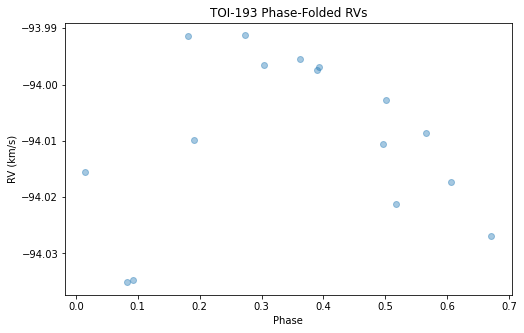

In [6]:
plt.figure(figsize=(8,5)) 
plt.title("TOI-193 Phase-Folded RVs")
plt.ylabel("RV (km/s)")
plt.xlabel("Phase")

plt.scatter([ttt % 0.79 for ttt in obs_data.time_series.times], calculated_vrad_list, alpha=0.4)

plt.show()


### 3 Using TIRAVEL to refine our RV measurements.


In [7]:
template_TIRAVEL = obs_data.time_series.TIRAVEL([calculated_vrad_list])
for i in obs_data.time_series.vals:
    i = i.TrimSpec(Ntrim=150)

In [8]:
# tir = deepcopy(template_star_broadend)

In [9]:
refined_vrad_list = obs_data.calc_rv_against_template(template_TIRAVEL, dv=0.1,
                                                         VelBound=[-117, 117], combine_ccfs=False,
                                                         fastccf=True).vels

100%|█| 16/16 [00:00<00:00, 42.91it/s


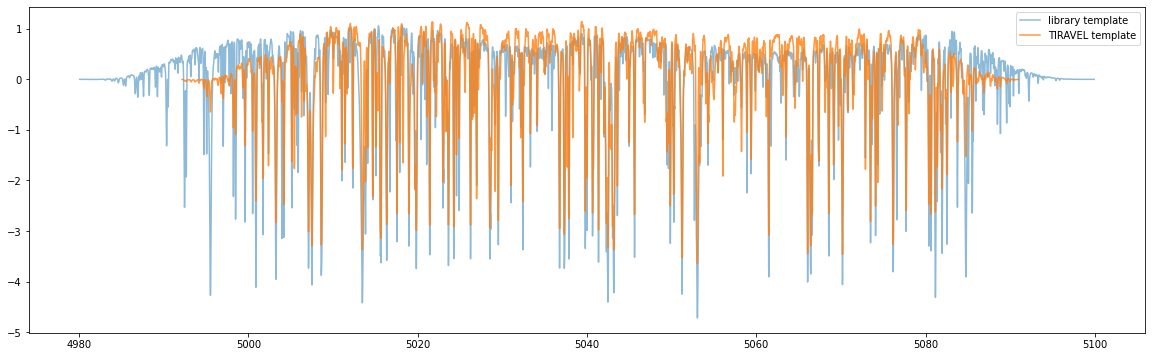

In [10]:
plt.figure(figsize=(20,6)) 
  
plt.plot(template_star_final.model.wv[0], template_star_final.model.sp[0], alpha=0.5)
plt.plot(template_TIRAVEL.model.wv[0], template_TIRAVEL.model.sp[0], alpha=0.8)

plt.legend(["library template", "TIRAVEL template"])

plt.show()

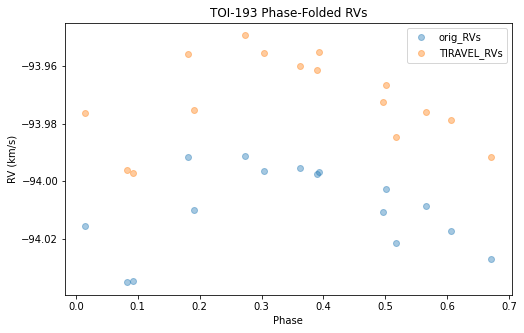

In [11]:
plt.figure(figsize=(8,5)) 
plt.title("TOI-193 Phase-Folded RVs")
plt.ylabel("RV (km/s)")
plt.xlabel("Phase")

plt.scatter([ttt  % 0.79 for ttt in obs_data.time_series.times], calculated_vrad_list, alpha=0.4)
plt.scatter([ttt  % 0.79 for ttt  in obs_data.time_series.times], refined_vrad_list, alpha=0.4)
plt.legend(["orig_RVs", "TIRAVEL_RVs"])

plt.show()

### 2. Using the PeriodicityDetector class to run GLS on the spectra

In [12]:
# PeriodicityDetector object initialization
obs_data.initialize_periodicity_detector(freq_range=(0.5, 2), periodogram_grid_resolution=1_000)
obs_data.periodicity_detector.period_truth = [0.792] # The published planetary period in days

First we will try running the GLS periodogram using our initial RV estimations.

In [13]:
obs_data.time_series.calculated_vrad_list = calculated_vrad_list

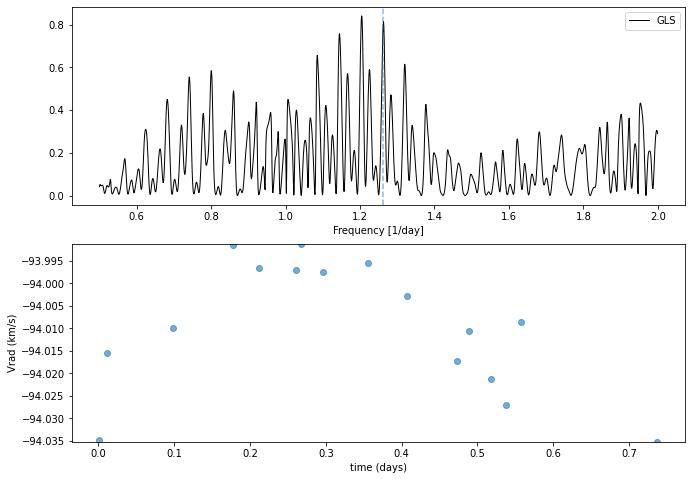

In [14]:
obs_data.periodicity_detector.calc_GLS()

obs_data.periodicity_detector.plot_periodograms(plot_vals=True)

plt.show()

The resulted periodogram doesn't present the highest peak in the expected published period.

Now we'll run the periodogram on the refined RV data.

In [15]:
obs_data.time_series.calculated_vrad_list = refined_vrad_list

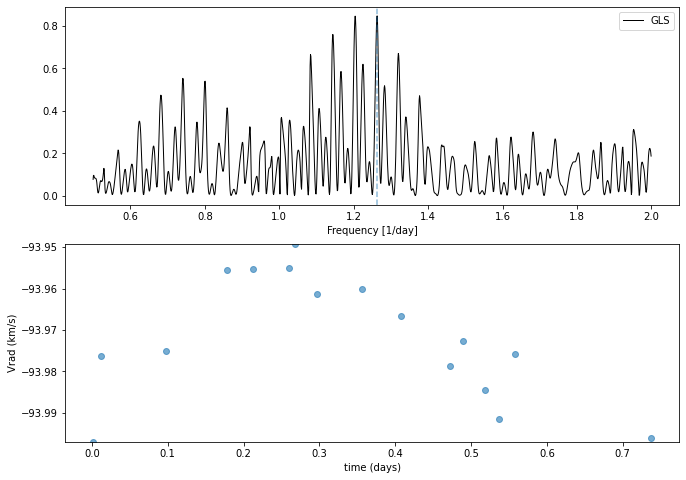

In [16]:
obs_data.periodicity_detector.calc_GLS()

obs_data.periodicity_detector.plot_periodograms(plot_vals=True)

plt.show()

As expected, the refined RV estimation present slightly better results in detecting the planetary period in the data.

Although this is not a significant enough detection example, it is a light-weight demonstration to the TIRAVEL advantages.